In [71]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [72]:
# Define the dataset directory paths
train_dir = "train"
test_dir = "test"

In [73]:
# Create a list of image paths and their corresponding FEN positions
train_data = []
test_data = []

In [74]:
for filename in os.listdir(train_dir):
    fen_position = os.path.splitext(filename)[0]  # Extract FEN from the filename without extension
    img_path = os.path.join(train_dir, filename)
    train_data.append((img_path, fen_position))

In [75]:
for filename in os.listdir(test_dir):
    fen_position = os.path.splitext(filename)[0]
    img_path = os.path.join(test_dir, filename)
    test_data.append((img_path, fen_position))

In [76]:
# Convert the lists to pandas DataFrames
train_df = pd.DataFrame(train_data, columns=['image_path', 'fen_position'])
test_df = pd.DataFrame(test_data, columns=['image_path', 'fen_position'])

In [77]:
# Merge the training and test DataFrames
combined_df = pd.concat([train_df, test_df], ignore_index=True)

In [78]:
# Create a mapping of FEN positions to numerical labels
fen_to_label = {fen: label for label, fen in enumerate(combined_df['fen_position'].unique())}

In [79]:
# Define the dataset class
class ChessDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        fen_position = self.data.iloc[idx]['fen_position']

        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        label = fen_to_label[fen_position]
        return img, label  # Return numerical label instead of FEN position

In [80]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [81]:
# Create the dataset and dataloaders
train_dataset = ChessDataset(train_df, transform=transform)
test_dataset = ChessDataset(test_df, transform=transform)

In [82]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [83]:
# Load the pre-trained CNN model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.data['fen_position'].unique()))

C:\Users\clint\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\clint\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [85]:
# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}")

Epoch 1/1, Loss: 8.786317236104589


In [105]:
 # Fine-tune the pre-trained model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}")

# Evaluation loop
model.eval()
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = 100 * correct_predictions / total_samples
print(f"Accuracy: {accuracy:.2f}%")


Epoch 1/10, Loss: 8.49457817928047
Epoch 2/10, Loss: 8.238867361834094
Epoch 3/10, Loss: 7.9955326827468385
Epoch 4/10, Loss: 7.768309338077618
Epoch 5/10, Loss: 7.5347654622071865
Epoch 6/10, Loss: 7.310671706108531
Epoch 7/10, Loss: 7.08852069696803
Epoch 8/10, Loss: 6.885089124084279
Epoch 9/10, Loss: 6.663360702004402
Epoch 10/10, Loss: 6.456398657173108
Accuracy: 0.00%


In [87]:
# BONUS: Application to predict FEN position from an image
def predict_position(image_path, model, transform):
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0)  # Add a batch dimension

    model.eval()
    with torch.no_grad():
        output = model(img)

    _, predicted_idx = torch.max(output, 1)
    predicted_position = train_dataset.data['fen_position'].unique()[predicted_idx]
    return predicted_position

In [93]:
# Example usage:
image_path = "1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpg"

In [94]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Combine the current directory with the relative file path
image_path = os.path.join(current_dir, "1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpg")


In [103]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Combine the current directory with the relative file path
image_path = os.path.join(current_dir, "1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg")

# Call the function to display the image
display_image(image_path)


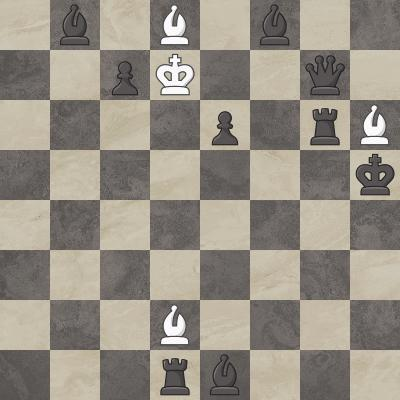

In [104]:
import os
from PIL import Image
from IPython.display import display

current_dir = os.getcwd()

image_path = os.path.join(current_dir, "1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg")

# to see the image
img = Image.open(image_path)

# Display the image
display(img)
